In [108]:
import pandas as pd
import numpy as np
from sklearn import preprocessing, svm
from sklearn.svm import LinearSVR
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import (SelectKBest, f_regression, mutual_info_regression)
from sklearn.metrics import (make_scorer, mean_absolute_error, mean_absolute_percentage_error,
                             mean_squared_error, r2_score, root_mean_squared_error)
from sklearn.model_selection import GridSearchCV, RepeatedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


1. Check the data first
2. Split data into train, validation, test data
3. Preprocess the data
    3A. Find Missing data and remove rows
    3B. Encode any categorical data
4. Train the model
    4A. Hypertune the model and find the best hyperparameters
5. See how the model works on the validation data (Accuracy)
6. Test the model on the test data

In [109]:
from sklearn.model_selection import train_test_split

# Read in the data
Housing_data = pd.read_csv('train.csv')
Housing_data_test = pd.read_csv('test.csv')

train_data = Housing_data.copy()
test_data = Housing_data_test.copy()

# Preprocessing: Remove any missing value rows
missing_values = train_data.isnull().sum()
missing_values

train_data.dropna()
test_data.dropna()

# Split features and target variable
X_train = train_data.drop('SalePrice', axis=1)
y_train = train_data['SalePrice']

X_test = test_data

In [110]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [111]:
# Check Variable Types
X_train.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MiscVal            int64
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
Length: 80, dtype: object

In [112]:
# Identify categorical columns for train data
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
categorical_cols

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [113]:
# Identify categorical columns for test data
categorical_cols_test = X_test.select_dtypes(include=['object', 'category']).columns
categorical_cols_test

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [114]:
# Apply one-hot encoding to the training, validation, and test set
X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_val = pd.get_dummies(X_val, columns=categorical_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_cols_test, drop_first=True)

In [115]:
# Ensure the same columns in all sets. Just checking
X_train, X_val = X_train.align(X_val, join='left', axis=1, fill_value=0)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [116]:
# Build the Random Forest model
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)#42 is a starting point

In [117]:
from sklearn.model_selection import GridSearchCV

# Setting the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum number of levels in each tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]     # Minimum number of samples required at each leaf node
}

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# After fitting, this find the best parameters and the best model
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Predict on validation data
y_val_pred = best_model.predict(X_val)

# Since 'neg_mean_squared_error' is used, the scores are negative. 
# To get the MSE, we take the negative of the best score to make it positive.
best_mse = -grid_search.best_score_
print(f"Best Mean Squared Error: {best_mse}")

# Calculate and print the evaluation metrics for the validation data
mae = mean_absolute_error(y_val, y_val_pred)
mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_val_pred)
mape = mean_absolute_percentage_error(y_val, y_val_pred) * 100

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R2 Score:", r2)
print("Mean Absolute Percentage Error (MAPE):", mape)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best Mean Squared Error: 968131027.4386244
Mean Absolute Error (MAE): 18138.14698197978
Mean Squared Error (MSE): 900150794.406523
Root Mean Squared Error (RMSE): 30002.513134844605
R2 Score: 0.8826450440187175
Mean Absolute Percentage Error (MAPE): 10.901682510070069


In [118]:
# Predict on the test data
y_test_pred = best_model.predict(X_test)

test_predictions = pd.DataFrame({
    'Id': X_test['Id'],  # or another identifier
    'PredictedValue': y_test_pred
})
test_predictions.to_csv('predictions.csv', index=False)

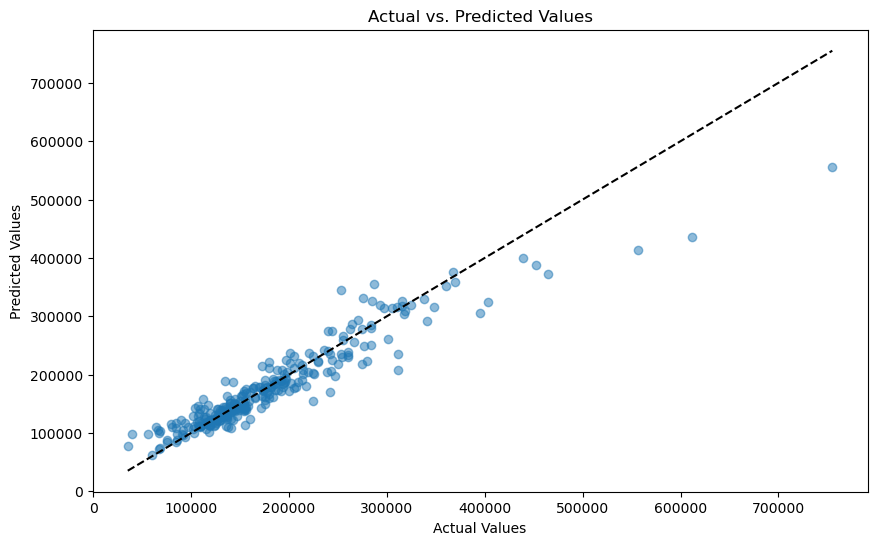

[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   8.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  18.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  15.1s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=  26.6s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=  22.0s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   6.6s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=  19.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  15.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  13.6s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estima

In [119]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_val_pred, alpha=0.5)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'k--')  # A diagonal line where actual = predicted
plt.show()